In [1]:
import pandas as pd
import yfinance as yf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import gurobipy as gp
from gurobipy import GRB

In [2]:
# function to fetch data from yahoo finance for 1 year
def FetchData(Tickers,Period="1y",Interval='1d',Start=None,End=None,Group_by='column',Column='Adj Close'):

    """
    Return the data for tickers
    Parameters:
        tickers : str, list             List of tickers to download
        period : str             Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max Either Use period parameter or use start and end
        interval : str             Valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo Intraday data cannot extend last 60 days
        start: str             Download start date string (YYYY-MM-DD) or _datetime. Default is 1900-01-01
        end: str             Download end date string (YYYY-MM-DD) or _datetime. Default is now
        group_by : str             Group by 'ticker' or 'column' (default)
    """
    StockData = yf.download(Tickers,start=Start,end=End,period=Period,interval=Interval)

    if Column!=None:
        SelectedData = StockData[Column]
    else:
        SelectedData = StockData

    return(SelectedData)



In [3]:
def Calculation(Data_Selected):
    ''' calculate the mean percent change and covariance for the stocks. Then annualized the value and return. '''
   
    Stock_pct_change = Data_Selected.pct_change()
    Mean_Change = Stock_pct_change.mean()*252
    Change_Cov = Stock_pct_change.cov()*252
    
    return(Mean_Change,Change_Cov)

In [4]:
def ComparitiveDisplay(StockData):
    # Display the growth of stocks by setting starting price to 100
    # The graph is displayed then
    ticker_list=StockData.columns
    temp_df = pd.DataFrame()
    for i in ticker_list:
        temp_df[i]=(StockData[i]/StockData[i][0])*100
    
        
    plt.figure(figsize=(20,5))
    sns.lineplot(data=temp_df)

    return()
    

In [5]:
# Selection of the Stocks for optimization
Tickers_List_small = ['GE','T','PG','AMZN','CL','CVS']
StockPrice = FetchData(Tickers_List_small)
Stock_Mean_Change, Stock_Cov_Change = Calculation(StockPrice)

[*********************100%***********************]  6 of 6 completed


()

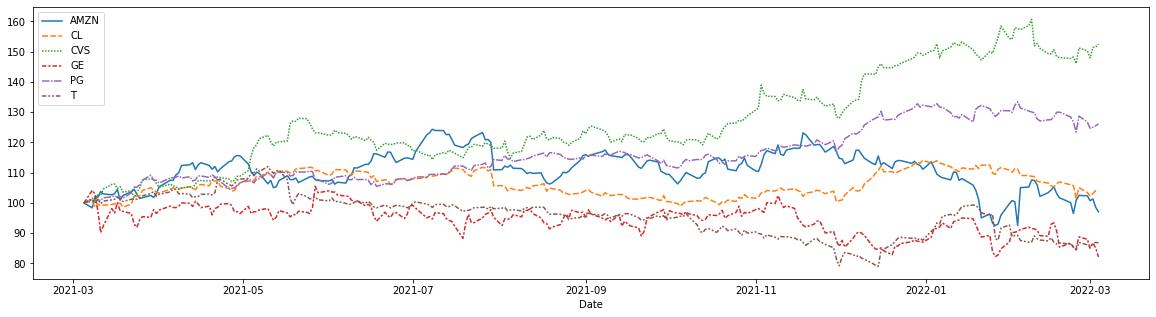

In [6]:
ComparitiveDisplay(StockPrice)

In [7]:
def Performance(weights, mean_change, change_cov):
    
    portfolio_return = np.dot(weights, mean_change)
    porfolio_std = np.dot(np.dot(change_cov, weights),weights)
    return(portfolio_return,porfolio_std)

In [8]:
Portfolio_Weights = np.ones(6)/6
Performance(Portfolio_Weights, Stock_Mean_Change, Stock_Cov_Change)

(0.0821167193785603, 0.01600894404421999)

In [9]:
def Efficient_Frontier_Montcarlo(Tickers,no_of_iter):
    stockdata = FetchData(Tickers)
    stock_mean_change, stock_cov_change = Calculation(stockdata)
    temp_data = pd.DataFrame(columns=['Return','Std_dev'])
    for i in range(no_of_iter):
        weights=np.random.random(6)
        portfolio_weights = weights/weights.sum()
        port_ret, port_std = Performance(portfolio_weights,stock_mean_change,stock_cov_change)
        temp1=pd.DataFrame([[port_ret,port_std]],columns=['Return','Std_dev'])
        temp_data = pd.concat([temp_data,temp1],ignore_index=True)
    plt.figure(figsize=(20,5))
    sns.scatterplot(data=temp_data,y='Return',x='Std_dev')
    return()

[*********************100%***********************]  6 of 6 completed


()

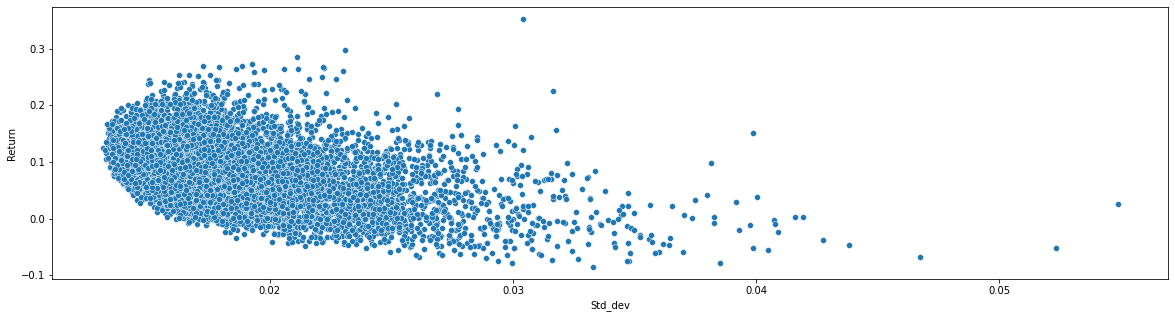

In [10]:
Efficient_Frontier_Montcarlo(Tickers_List_small,10000)

In [11]:
def SharpeRatio(Tickers,weights,RiskFreeRate):
    stockdata = FetchData(Tickers)
    stock_mean_change, stock_cov_change = Calculation(stockdata)
    port_ret, port_std = Performance(weights,stock_mean_change,stock_cov_change)

    return((port_ret-RiskFreeRate)/port_std)
    


In [12]:
SharpeRatio(Tickers_List_small, Portfolio_Weights, 0.025)

[*********************100%***********************]  6 of 6 completed


3.567797889952406

In [13]:
def OptimizedPortfolio(Tickers, Expectedreturn):

    stock_data = FetchData(Tickers)
    stock_mean_ret, stock_covariance = Calculation(stock_data)

    

    m = gp.Model('PortFolio optimization')

    weight = m.addMVar(len(Tickers))

    m.addConstr(weight.sum() == 1)
    port_std = weight @ stock_covariance.values @ weight
    port_ret = weight @ stock_mean_ret.values
    m.addConstr(port_ret == Expectedreturn)
    #m.addConstr(port_ret <= weight @ stock_mean_ret.values)

    
    m.setObjective(port_std, GRB.MINIMIZE)

    m.update()
    m.optimize()
    print(port_ret.getValue()[0])

    
    return(m.X)


In [14]:
Tickers_List = ['BRK-A', 'AAPL', 'MSFT', 'JPM', 'GOOG', 'BAC', 'INTC', 'WFC',
          'C', 'VZ', 'FB', 'PFE', 'JNJ', 'WMT', 'XOM',
          'FNMA', 'T', 'UNH', 'CMCSA', 'V' ]

In [15]:
def Efficient_Frontier_QP(Tickers,Resolution=4):

    stock_data = FetchData(Tickers)
    stock_mean_ret, stock_covariance = Calculation(stock_data)
    MinRet = stock_mean_ret.values.min()
    MaxRet = stock_mean_ret.values.max()
    m = gp.Model('PortFolio optimization')
    weight = m.addMVar(len(Tickers))
    m.addConstr(weight.sum() == 1)
    port_std = weight @ stock_covariance.values @ weight
    port_ret = weight @ stock_mean_ret.values
    returnrate = MinRet
    target = m.addConstr(port_ret == returnrate,'target')
    Frontier = pd.DataFrame([],columns=['Return','Std','Result'])
    for i in np.linspace(MinRet,MaxRet,Resolution):
        
        target[0].rhs = i
        #m.addConstr(port_ret <= weight @ stock_mean_ret.values)
        m.setObjective(port_std, GRB.MINIMIZE)
        m.update()
        m.optimize()
        temp = pd.DataFrame([[i,m.ObjVal,m.X]],columns=['Return','Std','Result'])

        Frontier = pd.concat([Frontier,temp],ignore_index=True)
    
    return(Frontier)

In [16]:
def DisplayEffFrontier(frontier_Cal):

    plt.figure(figsize=(20,5))

    a_plot=sns.scatterplot(data=frontier_Cal,x='Std',y='Return')
    a_plot.set(xlim=(0, frontier_Cal['Std'].max()))
    a_plot.set(ylim=(frontier_Cal['Return'].min(), frontier_Cal['Return'].max()+0.1))
    return()

In [17]:
Eff_Portfolio = Efficient_Frontier_QP(Tickers_List,200)
DisplayEffFrontier(Eff_Portfolio)

[*********************100%***********************]  20 of 20 completed
Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-03-17
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 20 columns and 40 nonzeros
Model fingerprint: 0xfa27f31f
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+00]
Presolve time: 0.39s
Presolved: 2 rows, 20 columns, 40 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 2.100e+02
 Factor NZ  : 2.310e+02
 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 

   2   2.24863846e+02 -6.80821074e+02  3.05e+01 1.35e-04  2.64e+03     0s
   3   3.96713081e-01 -4.38647450e+02  1.21e-01 5.34e-07  3.22e+01     0s
   4   4.56511242e-01 -1.45072675e+01  1.21e-07 5.34e-13  7.48e-01     0s
   5   4.56495837e-01  4.34132237e-01  5.44e-11 2.39e-16  1.12e-03     0s
   6   4.52817988e-01  4.49270800e-01  5.31e-12 2.78e-17  1.77e-04     0s
   7   4.50424836e-01  4.49323089e-01  3.89e-14 6.24e-16  5.51e-05     0s
   8   4.49662441e-01  4.49656406e-01  3.69e-14 6.66e-16  3.02e-07     0s
   9   4.49656833e-01  4.49656827e-01  2.94e-13 8.88e-16  3.02e-10     0s

Barrier solved model in 9 iterations and 0.02 seconds (0.00 work units)
Optimal objective 4.49656833e-01

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 20 columns and 40 nonzeros
Model fingerprint: 0xca6ffdd0
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     

  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+00]
Presolve time: 0.01s
Presolved: 2 rows, 20 columns, 40 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 2.100e+02
 Factor NZ  : 2.310e+02
 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.64495162e+05 -1.64495162e+05  1.28e+04 5.68e-02  1.00e+06     0s
   1   6.75061807e+04 -6.77668955e+04  1.25e+03 5.56e-03  1.03e+05     0s
   2   2.24625087e+02 -6.79394027e+02  3.05e+01 1.36e-04  2.64e+03     0s
   3   3.67379820e-01 -4.39023349e+02  1.08e-01 4.82e-07  3.11e+01     0s
   4   4.11903724e-01 -2.61585657e+01  6.94e-05 3.09e-10  1.33e+00     0s
   5   4.11957673e-01  3.66815849e-01  4.55e-08 2.03e-13  2.26e-03     0s
   6   4.01485338e-01  3.94237084e-01  2.37e-09 1.06e-14  3.62e-0

   5   3.85161104e-01  3.19500948e-01  4.54e-07 2.04e-12  3.28e-03     0s
   6   3.65165052e-01  3.53023533e-01  5.81e-09 2.61e-14  6.07e-04     0s
   7   3.58177004e-01  3.54598449e-01  4.04e-14 4.44e-16  1.79e-04     0s
   8   3.55824218e-01  3.55787268e-01  3.85e-14 4.44e-16  1.85e-06     0s
   9   3.55791725e-01  3.55791688e-01  2.34e-14 4.44e-16  1.84e-09     0s
  10   3.55791693e-01  3.55791693e-01  7.47e-14 6.66e-16  1.85e-12     0s

Barrier solved model in 10 iterations and 0.02 seconds (0.00 work units)
Optimal objective 3.55791693e-01

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 20 columns and 40 nonzeros
Model fingerprint: 0x3f690a2d
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+

Presolved: 2 rows, 20 columns, 40 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 2.100e+02
 Factor NZ  : 2.310e+02
 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.64518489e+05 -1.64518489e+05  1.27e+04 5.77e-02  1.00e+06     0s
   1   6.75031191e+04 -6.77690748e+04  1.25e+03 5.64e-03  1.03e+05     0s
   2   2.24195939e+02 -6.76815041e+02  3.05e+01 1.38e-04  2.64e+03     0s
   3   3.19537198e-01 -4.39490890e+02  8.95e-02 4.05e-07  2.95e+01     0s
   4   3.49081711e-01 -3.49331346e+01  2.24e-04 1.02e-09  1.78e+00     0s
   5   3.49139697e-01  2.66386848e-01  2.77e-07 1.25e-12  4.14e-03     0s
   6   3.20552297e-01  3.04987569e-01  2.50e-09 1.13e-14  7.78e-04     0s
   7   3.11945598e-01  3.08059422e-01  1.54e-14 4.44e-16  1.94e-04     0s
   8  

   9   2.74821940e-01  2.74820679e-01  1.11e-13 4.44e-16  6.30e-08     0s
  10   2.74820750e-01  2.74820736e-01  2.68e-12 4.44e-16  7.09e-10     0s
  11   2.74820736e-01  2.74820736e-01  2.65e-12 6.66e-16  7.10e-13     0s

Barrier solved model in 11 iterations and 0.02 seconds (0.00 work units)
Optimal objective 2.74820736e-01

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 20 columns and 40 nonzeros
Model fingerprint: 0x1556ecb2
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+00]
Presolve time: 0.00s
Presolved: 2 rows, 20 columns, 40 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 2.100e+02
 Factor NZ  : 2.310e+

Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 2.100e+02
 Factor NZ  : 2.310e+02
 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.64541817e+05 -1.64541817e+05  1.27e+04 5.86e-02  1.00e+06     0s
   1   6.75000576e+04 -6.77712521e+04  1.25e+03 5.73e-03  1.03e+05     0s
   2   2.23767583e+02 -6.74222812e+02  3.06e+01 1.40e-04  2.64e+03     0s
   3   2.75640944e-01 -4.39681562e+02  7.16e-02 3.29e-07  2.80e+01     0s
   4   2.91336712e-01 -3.11223616e+01  7.16e-08 3.29e-13  1.57e+00     0s
   5   2.91129860e-01  1.89487715e-01  1.41e-10 6.45e-16  5.08e-03     0s
   6   2.50608227e-01  2.27279802e-01  2.66e-14 4.44e-16  1.17e-03     0s
   7   2.38539420e-01  2.33170219e-01  1.65e-14 4.44e-16  2.68e-04     0s
   8   2.35100459e-01  2.35057634e-01  1.24e-14 4.44e-16  2.14e-06     0s
   9   2.35071751e-01  2.

  10   2.05897541e-01  2.05897541e-01  1.79e-14 2.22e-16  2.81e-12     0s

Barrier solved model in 10 iterations and 0.02 seconds (0.00 work units)
Optimal objective 2.05897541e-01

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 20 columns and 40 nonzeros
Model fingerprint: 0x49dd2365
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+00]
Presolve time: 0.00s
Presolved: 2 rows, 20 columns, 40 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 2.100e+02
 Factor NZ  : 2.310e+02
 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal

   0   1.64565146e+05 -1.64565146e+05  1.27e+04 5.95e-02  1.00e+06     0s
   1   6.74969963e+04 -6.77734275e+04  1.25e+03 5.82e-03  1.03e+05     0s
   2   2.23340021e+02 -6.71617340e+02  3.06e+01 1.43e-04  2.65e+03     0s
   3   2.35173287e-01 -4.39591861e+02  5.36e-02 2.50e-07  2.65e+01     0s
   4   2.41762488e-01 -2.22732298e+01  5.36e-08 2.50e-13  1.13e+00     0s
   5   2.41357624e-01  1.28315865e-01  1.79e-10 8.33e-16  5.65e-03     0s
   6   1.85420212e-01  1.40081354e-01  6.44e-15 4.44e-16  2.27e-03     0s
   7   1.74426192e-01  1.71856652e-01  4.16e-15 4.44e-16  1.28e-04     0s
   8   1.72814350e-01  1.72682899e-01  8.88e-15 6.59e-16  6.57e-06     0s
   9   1.72705410e-01  1.72705234e-01  1.73e-14 4.44e-16  8.78e-09     0s
  10   1.72705257e-01  1.72705256e-01  2.41e-14 3.53e-16  8.79e-12     0s

Barrier solved model in 10 iterations and 0.01 seconds (0.00 work units)
Optimal objective 1.72705257e-01

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physica

Optimize a model with 2 rows, 20 columns and 40 nonzeros
Model fingerprint: 0xff9fa9ae
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+00]
Presolve time: 0.00s
Presolved: 2 rows, 20 columns, 40 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 2.100e+02
 Factor NZ  : 2.310e+02
 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.64578108e+05 -1.64578108e+05  1.28e+04 5.99e-02  1.00e+06     0s
   1   6.74952957e+04 -6.77746352e+04  1.25e+03 5.87e-03  1.03e+05     0s
   2   2.23102830e+02 -6.70164133e+02  3.06e+01 1.44e-04  2.65e+03     0s
   3   2.14169925e-01 -4.39420772e

   0   1.64588478e+05 -1.64588478e+05  1.27e+04 6.03e-02  1.00e+06     0s
   1   6.74939353e+04 -6.77756009e+04  1.25e+03 5.90e-03  1.03e+05     0s
   2   2.22913253e+02 -6.68998625e+02  3.06e+01 1.45e-04  2.65e+03     0s
   3   1.98126440e-01 -4.39221522e+02  3.54e-02 1.67e-07  2.50e+01     0s
   4   1.99836891e-01 -1.17590204e+01  3.54e-08 1.67e-13  5.98e-01     0s
   5   1.98902657e-01  7.91300948e-02  2.51e-10 1.19e-15  5.99e-03     0s
   6   1.37656051e-01  7.48380284e-02  2.61e-15 4.44e-16  3.14e-03     0s
   7   1.24591285e-01  1.20100214e-01  4.14e-15 5.00e-16  2.25e-04     0s
   8   1.22269617e-01  1.21938782e-01  3.22e-15 4.44e-16  1.65e-05     0s
   9   1.22112108e-01  1.22109557e-01  7.72e-15 1.84e-16  1.28e-07     0s
  10   1.22111797e-01  1.22111787e-01  5.79e-13 2.22e-16  4.97e-10     0s

Barrier solved model in 10 iterations and 0.01 seconds (0.00 work units)
Optimal objective 1.22111797e-01

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physica

Optimize a model with 2 rows, 20 columns and 40 nonzeros
Model fingerprint: 0x056a432f
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+00]
Presolve time: 0.00s
Presolved: 2 rows, 20 columns, 40 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 2.100e+02
 Factor NZ  : 2.310e+02
 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.64601440e+05 -1.64601440e+05  1.27e+04 6.08e-02  1.00e+06     0s
   1   6.74922348e+04 -6.77768075e+04  1.25e+03 5.95e-03  1.03e+05     0s
   2   2.22676501e+02 -6.67538062e+02  3.06e+01 1.46e-04  2.65e+03     0s
   3   1.79519187e-01 -4.38895852e

   4   1.65820110e-01 -4.56738138e+00  2.09e-08 1.00e-13  2.37e-01     0s
   5   1.62648930e-01  3.58929826e-02  3.33e-10 1.60e-15  6.34e-03     0s
   6   1.06657743e-01  7.56395318e-03  1.39e-15 7.77e-16  4.95e-03     0s
   7   8.82616185e-02  7.73464282e-02  3.61e-15 3.89e-16  5.46e-04     0s
   8   8.28096119e-02  8.22179132e-02  2.66e-15 2.22e-16  2.96e-05     0s
   9   8.24873654e-02  8.24856482e-02  5.44e-15 1.11e-16  8.59e-08     0s
  10   8.24868478e-02  8.24868461e-02  5.38e-15 2.41e-16  8.59e-11     0s

Barrier solved model in 10 iterations and 0.02 seconds (0.00 work units)
Optimal objective 8.24868478e-02

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 20 columns and 40 nonzeros
Model fingerprint: 0xc6b3f722
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-0

  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+00]
Presolve time: 0.00s
Presolved: 2 rows, 20 columns, 40 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 2.100e+02
 Factor NZ  : 2.310e+02
 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.64624774e+05 -1.64624774e+05  1.27e+04 6.17e-02  1.00e+06     0s
   1   6.74891741e+04 -6.77789779e+04  1.25e+03 6.04e-03  1.03e+05     0s
   2   2.22250966e+02 -6.64898747e+02  3.07e+01 1.48e-04  2.65e+03     0s
   3   1.50820778e-01 -4.38102942e+02  1.46e-02 7.05e-08  2.31e+01     0s
   4   1.49914873e-01 -2.33925381e+00  6.25e-07 3.02e-12  1.24e-01     0s
   5   1.42010897e-01  1.42068678e-02  1.52e-08 7.35e-14  6.39e-03     

   3   1.39011437e-01 -4.37663069e+02  9.45e-03 4.60e-08  2.27e+01     0s
   4   1.38191967e-01 -1.09290737e+00  6.78e-07 3.30e-12  6.16e-02     0s
   5   1.19258688e-01 -4.30843018e-05  3.99e-08 1.94e-13  5.97e-03     0s
   6   7.44666213e-02  1.30571574e-03  4.00e-14 5.55e-17  3.66e-03     0s
   7   5.83245791e-02  4.89326829e-02  5.00e-16 2.91e-16  4.70e-04     0s
   8   5.38584166e-02  5.29630675e-02  7.27e-15 1.11e-16  4.48e-05     0s
   9   5.34110123e-02  5.33941859e-02  2.72e-15 1.11e-16  8.41e-07     0s
  10   5.34016072e-02  5.34015714e-02  1.59e-14 5.46e-17  1.79e-09     0s
  11   5.34015787e-02  5.34015786e-02  1.05e-13 1.11e-16  1.79e-12     0s

Barrier solved model in 11 iterations and 0.01 seconds (0.00 work units)
Optimal objective 5.34015787e-02

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 20 columns and 40 nonzeros
Model fingerprint: 0x39b980ae
Model ha


Barrier solved model in 12 iterations and 0.02 seconds (0.00 work units)
Optimal objective 4.38576138e-02

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 20 columns and 40 nonzeros
Model fingerprint: 0xd73f4c99
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+00]
Presolve time: 0.00s
Presolved: 2 rows, 20 columns, 40 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 2.100e+02
 Factor NZ  : 2.310e+02
 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.64648110

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.64658482e+05 -1.64658482e+05  1.28e+04 6.30e-02  1.00e+06     0s
   1   6.74847535e+04 -6.77821094e+04  1.25e+03 6.17e-03  1.03e+05     0s
   2   2.21637704e+02 -6.61063026e+02  3.07e+01 1.52e-04  2.65e+03     0s
   3   1.15171707e-01 -4.36478283e+02  3.07e-05 1.52e-10  2.18e+01     0s
   4   1.15116010e-01 -4.92583292e-01  1.20e-08 5.95e-14  3.04e-02     0s
   5   7.73612197e-02 -1.41247092e-02  7.32e-10 3.61e-15  4.57e-03     0s
   6   4.92663039e-02 -1.46556482e-02  7.77e-16 1.11e-16  3.20e-03     0s
   7   4.01542115e-02  2.50468161e-02  1.11e-16 2.22e-16  7.55e-04     0s
   8   3.58121740e-02  3.37680594e-02  1.14e-15 1.11e-16  1.02e-04     0s
   9   3.47668758e-02  3.46716664e-02  1.64e-15 5.55e-17  4.76e-06     0s
  10   3.47079223e-02  3.47078270e-02  2.66e-15 5.55e-17  4.77e-09     0s
  11   3.47078634e-02  3.47078633e-02  1.75e-15 5.55e-17  4.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+00]
Presolve time: 0.02s
Presolved: 2 rows, 20 columns, 40 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 2.100e+02
 Factor NZ  : 2.310e+02
 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.64798534e+05 -1.64798534e+05  1.27e+04 6.83e-02  1.00e+06     0s
   1   6.74664260e+04 -6.77951036e+04  1.25e+03 6.69e-03  1.03e+05     0s
   2   2.19110575e+02 -6.44836025e+02  3.09e+01 1.65e-04  2.67e+03     0s
   3   3.44532863e-02 -4.24020996e+02  3.09e-05 1.65e-10  2.12e+01     0s
   4   3.44400285e-02 -4.75422025e-01  6.25e-09 3.35e-14  2.55e-02     0s
   5   2.6058

 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.64808911e+05 -1.64808911e+05  1.27e+04 6.87e-02  1.00e+06     0s
   1   6.74650580e+04 -6.77960527e+04  1.25e+03 6.72e-03  1.03e+05     0s
   2   2.18924205e+02 -6.43614744e+02  3.09e+01 1.66e-04  2.67e+03     0s
   3   3.11514713e-02 -4.22727011e+02  3.09e-05 1.66e-10  2.11e+01     0s
   4   3.11402952e-02 -4.69764115e-01  5.72e-09 3.08e-14  2.50e-02     0s
   5   2.42486973e-02 -2.37160840e-02  3.44e-10 1.86e-15  2.40e-03     0s
   6   1.35889605e-02 -3.94960121e-03  3.89e-16 6.94e-18  8.77e-04     0s
   7   1.03298202e-02  7.14692303e-03  8.33e-17 4.22e-17  1.59e-04     0s
   8   9.40715977e-03  8.99768431e-03  5.55e-17 1.13e-17  2.05e-05     0s
   9   9.21126301e-03  9.17879468e-03  5.55e-16 1.54e-17  1.62e-06     0s
  10   9.19089584e-03  9.18973365e-03  1.28e-15 1.97e-17  

   1   6.74636710e+04 -6.77969823e+04  1.25e+03 6.76e-03  1.03e+05     0s
   2   2.18737415e+02 -6.42390179e+02  3.09e+01 1.67e-04  2.67e+03     0s
   3   2.82115309e-02 -4.21381618e+02  3.09e-05 1.67e-10  2.11e+01     0s
   4   2.82022241e-02 -4.63681510e-01  5.17e-09 2.80e-14  2.46e-02     0s
   5   2.26720555e-02 -2.07341087e-02  2.89e-10 1.57e-15  2.17e-03     0s
   6   1.25162991e-02 -3.66474185e-03  4.44e-16 6.94e-18  8.09e-04     0s
   7   1.00354998e-02  7.67421456e-03  4.16e-17 2.43e-17  1.18e-04     0s
   8   9.28903447e-03  8.95485561e-03  8.33e-17 6.94e-18  1.67e-05     0s
   9   9.14264758e-03  9.11909225e-03  1.18e-16 2.82e-17  1.18e-06     0s
  10   9.12759648e-03  9.12639062e-03  2.23e-15 1.83e-17  6.03e-08     0s
  11   9.12681453e-03  9.12677783e-03  1.43e-14 5.25e-17  1.83e-09     0s
  12   9.12680933e-03  9.12680917e-03  1.14e-13 3.70e-17  7.88e-12     0s

Barrier solved model in 12 iterations and 0.02 seconds (0.00 work units)
Optimal objective 9.12680933e-03

Guro

   7   9.90197313e-03  7.89252020e-03  4.16e-17 2.43e-17  1.00e-04     0s
   8   9.27648065e-03  8.97267496e-03  1.22e-15 1.69e-17  1.52e-05     0s
   9   9.15573318e-03  9.12428233e-03  6.94e-17 2.82e-17  1.57e-06     0s
  10   9.14192534e-03  9.14020239e-03  1.26e-15 2.46e-17  8.61e-08     0s
  11   9.14109380e-03  9.14099923e-03  5.01e-14 1.05e-17  4.73e-09     0s
  12   9.14102240e-03  9.14102078e-03  3.80e-13 2.21e-17  8.11e-11     0s

Barrier solved model in 12 iterations and 0.02 seconds (0.00 work units)
Optimal objective 9.14102240e-03

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 20 columns and 40 nonzeros
Model fingerprint: 0x09f732fd
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+

  12   9.22401097e-03  9.22401066e-03  3.37e-13 1.48e-17  1.58e-11     0s

Barrier solved model in 12 iterations and 0.02 seconds (0.00 work units)
Optimal objective 9.22401097e-03

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 20 columns and 40 nonzeros
Model fingerprint: 0x953e2843
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+00]
Presolve time: 0.00s
Presolved: 2 rows, 20 columns, 40 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 2.100e+02
 Factor NZ  : 2.310e+02
 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal

Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+00]
Presolve time: 0.00s
Presolved: 2 rows, 20 columns, 40 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 2.100e+02
 Factor NZ  : 2.310e+02
 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.64853015e+05 -1.64853015e+05  1.27e+04 7.04e-02  1.00e+06     0s
   1   6.74606687e+04 -6.78015054e+04  1.25e+03 6.89e-03  1.03e+05     0s
   2   2.18119890e+02 -6.38380986e+02  3.09e+01 1.71e-04  2.67e+03     0s
   3   2.11460173e-02 -4.16654366e+02  3.09e-05 1.71e-10  2.08e+01     0s
   4   2.11413769e-02 -4.41349487e-01  3.41e-09 1.88e-14  2.31e-02     0s
   5   1.8800

 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.64863394e+05 -1.64863394e+05  1.27e+04 7.08e-02  1.00e+06     0s
   1   6.74609892e+04 -6.78041401e+04  1.25e+03 6.93e-03  1.03e+05     0s
   2   2.17917571e+02 -6.37129331e+02  3.09e+01 1.72e-04  2.67e+03     0s
   3   1.97349586e-02 -4.15090515e+02  3.09e-05 1.72e-10  2.08e+01     0s
   4   1.97313448e-02 -4.33854349e-01  2.87e-09 1.60e-14  2.27e-02     0s
   5   1.79676502e-02 -1.36260933e-02  1.29e-10 7.22e-16  1.58e-03     0s
   6   1.15835605e-02  4.91845817e-04  1.67e-16 4.16e-17  5.55e-04     0s
   7   1.02010061e-02  8.97614384e-03  5.55e-17 2.60e-17  6.12e-05     0s
   8   9.74167701e-03  9.56199953e-03  1.64e-15 1.73e-17  8.98e-06     0s
   9   9.66632799e-03  9.65644363e-03  8.33e-17 2.31e-17  4.94e-07     0s
  10   9.66137482e-03  9.66099167e-03  6.11e-15 1.04e-17  

   3   1.86819561e-02 -4.13474924e+02  3.09e-05 1.73e-10  2.07e+01     0s
   4   1.86791871e-02 -4.28267832e-01  2.51e-09 1.40e-14  2.23e-02     0s
   5   1.73220168e-02 -1.16248074e-02  1.05e-10 5.86e-16  1.45e-03     0s
   6   1.17640831e-02  2.06996727e-03  5.55e-17 6.94e-18  4.85e-04     0s
   7   1.04981018e-02  9.45670566e-03  5.55e-17 2.08e-17  5.21e-05     0s
   8   1.00668689e-02  9.92393137e-03  6.11e-16 2.34e-17  7.15e-06     0s
   9   1.00044396e-02  9.99842372e-03  1.67e-16 1.39e-17  3.01e-07     0s
  10   1.00014066e-02  1.00010459e-02  8.83e-15 8.67e-18  1.80e-08     0s
  11   1.00012047e-02  1.00011558e-02  5.47e-14 2.12e-17  2.45e-09     0s
  12   1.00011685e-02  1.00011650e-02  1.77e-14 1.44e-17  1.75e-10     0s

Barrier solved model in 12 iterations and 0.02 seconds (0.00 work units)
Optimal objective 1.00011685e-02

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with

   9   1.04367871e-02  1.04324671e-02  1.39e-16 2.08e-17  2.16e-07     0s
  10   1.04344437e-02  1.04341596e-02  1.08e-14 6.94e-18  1.42e-08     0s
  11   1.04342086e-02  1.04341948e-02  2.51e-14 6.94e-18  6.87e-10     0s
  12   1.04341954e-02  1.04341954e-02  2.15e-14 1.04e-17  6.77e-13     0s

Barrier solved model in 12 iterations and 0.02 seconds (0.00 work units)
Optimal objective 1.04341954e-02

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 20 columns and 40 nonzeros
Model fingerprint: 0xa49676e3
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+00]
Presolve time: 0.02s
Presolved: 2 rows, 20 columns, 40 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier 

Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+00]
Presolve time: 0.01s
Presolved: 2 rows, 20 columns, 40 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 2.100e+02
 Factor NZ  : 2.310e+02
 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.64897125e+05 -1.64897125e+05  1.27e+04 7.21e-02  1.00e+06     0s
   1   6.74619162e+04 -6.78125845e+04  1.25e+03 7.05e-03  1.03e+05     0s
   2   2.17259780e+02 -6.33040589e+02  3.10e+01 1.75e-04  2.68e+03     0s
   3   1.76176132e-02 -4.09650093e+02  3.10e-05 1.75e-10  2.05e+01     0s
   4   1.76160744e-02 -4.16519566e-01  1.86e-09 1.05e-14  2.17e-02     0s
   5   1.6768

   2   2.17057474e+02 -6.31776285e+02  3.10e+01 1.76e-04  2.68e+03     0s
   3   1.80848179e-02 -4.07946296e+02  9.47e-03 5.38e-08  2.12e+01     0s
   4   1.78731410e-02 -1.87381397e+00  1.45e-05 8.26e-11  9.46e-02     0s
   5   1.76271444e-02 -4.46168830e-03  1.00e-07 5.70e-13  1.10e-03     0s
   6   1.33813915e-02  7.25796310e-03  1.00e-13 6.94e-18  3.06e-04     0s
   7   1.22275274e-02  1.13284911e-02  2.22e-16 1.39e-17  4.50e-05     0s
   8   1.18286072e-02  1.17365838e-02  8.88e-16 8.84e-18  4.60e-06     0s
   9   1.17815648e-02  1.17794625e-02  4.16e-16 2.78e-17  1.05e-07     0s
  10   1.17799367e-02  1.17798992e-02  8.72e-15 1.16e-17  1.88e-09     0s
  11   1.17799001e-02  1.17799001e-02  4.88e-14 1.39e-17  1.87e-12     0s

Barrier solved model in 11 iterations and 0.02 seconds (0.00 work units)
Optimal objective 1.17799001e-02

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with

  11   1.25700855e-02  1.25700853e-02  5.16e-15 2.08e-17  1.07e-11     0s

Barrier solved model in 11 iterations and 0.00 seconds (0.00 work units)
Optimal objective 1.25700855e-02

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 20 columns and 40 nonzeros
Model fingerprint: 0xa2999b30
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+00]
Presolve time: 0.00s
Presolved: 2 rows, 20 columns, 40 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 2.100e+02
 Factor NZ  : 2.310e+02
 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal

  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+00]
Presolve time: 0.00s
Presolved: 2 rows, 20 columns, 40 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 2.100e+02
 Factor NZ  : 2.310e+02
 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.64930861e+05 -1.64930861e+05  1.27e+04 7.33e-02  1.00e+06     0s
   1   6.74627960e+04 -6.78209768e+04  1.25e+03 7.18e-03  1.03e+05     0s
   2   2.16602894e+02 -6.28921430e+02  3.10e+01 1.78e-04  2.68e+03     0s
   3   1.96598021e-02 -4.03725435e+02  5.91e-02 3.40e-07  2.52e+01     0s
   4   1.81697242e-02 -2.79013865e+01  1.02e-03 5.89e-09  1.41e+00     0s
   5   1.80910473e-02 -2.53087353e-02  5.50e-07 3.17e-12  2.17e-03     0s
   6   1.61799501e-02  1.00050384e-02  5.01e-08 2.88e-13  3.09e-0

   3   2.05022154e-02 -4.01742358e+02  8.11e-02 4.69e-07  2.69e+01     0s
   4   1.83497221e-02 -6.53886937e+01  1.64e-03 9.51e-09  3.35e+00     0s
   5   1.82851982e-02 -1.10604805e-01  1.64e-09 9.51e-15  6.44e-03     0s
   6   1.73203063e-02  1.03627841e-02  4.74e-11 2.78e-16  3.48e-04     0s
   7   1.55530546e-02  1.27522919e-02  2.22e-16 2.08e-17  1.40e-04     0s
   8   1.49797787e-02  1.46905043e-02  6.38e-16 1.89e-17  1.45e-05     0s
   9   1.48348959e-02  1.48168735e-02  6.27e-15 1.39e-17  9.01e-07     0s
  10   1.48221048e-02  1.48213864e-02  2.39e-14 1.39e-17  3.59e-08     0s
  11   1.48214541e-02  1.48214404e-02  1.92e-12 1.39e-17  6.83e-10     0s
  12   1.48214406e-02  1.48214406e-02  1.35e-12 1.39e-17  6.80e-13     0s

Barrier solved model in 12 iterations and 0.02 seconds (0.00 work units)
Optimal objective 1.48214406e-02

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with


Barrier solved model in 11 iterations and 0.02 seconds (0.00 work units)
Optimal objective 1.61582204e-02

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 20 columns and 40 nonzeros
Model fingerprint: 0xa6a34d9f
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+00]
Presolve time: 0.00s
Presolved: 2 rows, 20 columns, 40 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 2.100e+02
 Factor NZ  : 2.310e+02
 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.64954218

Presolved: 2 rows, 20 columns, 40 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 2.100e+02
 Factor NZ  : 2.310e+02
 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.64964600e+05 -1.64964600e+05  1.27e+04 7.46e-02  1.00e+06     0s
   1   6.74636719e+04 -6.78293600e+04  1.25e+03 7.30e-03  1.03e+05     0s
   2   2.15947472e+02 -6.24772507e+02  3.11e+01 1.82e-04  2.68e+03     0s
   3   2.26815554e-02 -3.97038760e+02  1.30e-01 7.64e-07  3.09e+01     0s
   4   2.15269269e-02 -9.39533503e+01  7.88e-03 4.61e-08  5.78e+00     0s
   5   2.46544125e-02 -6.64925844e+00  7.88e-09 4.61e-14  3.34e-01     0s
   6   2.42960311e-02 -6.41671498e-02  9.09e-11 5.31e-16  4.42e-03     0s
   7   1.98539231e-02  1.11834177e-02  7.94e-15 6.66e-16  4.34e-04     0s
   8  


                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.64974981e+05 -1.64974981e+05  1.27e+04 7.50e-02  1.00e+06     0s
   1   6.74638841e+04 -6.78318811e+04  1.25e+03 7.34e-03  1.03e+05     0s
   2   2.15746073e+02 -6.23489772e+02  3.11e+01 1.83e-04  2.68e+03     0s
   3   2.37791622e-02 -3.94841397e+02  1.52e-01 8.97e-07  3.26e+01     0s
   4   2.37329631e-02 -6.59498524e+01  1.94e-02 1.14e-07  6.68e+00     0s
   5   4.22130443e-02 -2.71263378e+01  1.94e-08 1.14e-13  1.36e+00     0s
   6   4.19370785e-02 -1.98090648e-01  1.52e-10 9.02e-16  1.20e-02     0s
   7   2.99564093e-02 -4.56502536e-02  7.85e-15 9.77e-15  3.78e-03     0s
   8   2.36267310e-02  1.07717351e-02  6.44e-15 1.15e-15  6.43e-04     0s
   9   2.17840835e-02  1.98599679e-02  2.61e-13 2.22e-16  9.62e-05     0s
  10   2.09864569e-02  2.05583123e-02  4.90e-14 1.39e-16  2.14e-05     0s
  11   2.07858857e-02  2.07510045e-02  2.45e-14 6.13e-17  1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [68]:
def EfficientVsRiskFree(Portfolio_Data,RiskFreeRate):
    temp=0
    for i in range(len(Portfolio_Data)):
        Port_ret = Portfolio_Data.loc[i,'Return']
        Std_ret = Portfolio_Data.loc[i,'Std']
        slope = (Port_ret - RiskFreeRate)/(Std_ret - 0)
        if slope> temp:
            temp=max(temp,slope)
            b=Portfolio_Data.loc[i,:]
    return(b)


In [69]:
BestPortfolio = EfficientVsRiskFree(Eff_Portfolio,0.025)

In [70]:
print(BestPortfolio.Result)

[0.05478527029171163, 2.5419932506820063e-11, 0.1733802809735159, 5.608004314307028e-12, 9.793347393541541e-12, 5.5627773860911765e-12, 1.027163710421239e-11, 3.926643484296273e-08, 7.972315136601432e-12, 2.2682468054095913e-08, 6.53942657786158e-12, 0.11682400607924474, 0.14539035557010202, 1.7227363786243662e-11, 0.19671569877283732, 8.26719012283974e-12, 0.05541782485315842, 1.055936808521839e-10, 0.12486290178564287, 0.13262359952272224]


In [71]:
def OptimizedSelectPortfolio(Tickers, Expectedreturn, NoOfSelection):

    stock_data = FetchData(Tickers)
    stock_mean_ret, stock_covariance = Calculation(stock_data)

    

    m = gp.Model('PortFolio optimization')

    weight = m.addMVar(len(Tickers))
    Stock_Selected = m.addMVar(len(Tickers),vtype=GRB.BINARY)

    for i in range(len(Tickers)):
        m.addConstr(Stock_Selected[i]>=weight[i])

    m.addConstr(Stock_Selected.sum() <= NoOfSelection)
    m.addConstr(weight.sum() == 1)
    port_std = weight @ stock_covariance.values @ weight
    port_ret = weight @ stock_mean_ret.values
    m.addConstr(port_ret == Expectedreturn)
    #m.addConstr(port_ret <= weight @ stock_mean_ret.values)

    
    m.setObjective(port_std, GRB.MINIMIZE)

    m.update()
    m.optimize()
    print(port_ret.getValue()[0])

    
    return(m.X)

In [72]:
returndf = OptimizedSelectPortfolio(Tickers_List,0.30,5)

[*********************100%***********************]  20 of 20 completed
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0xe5e4732b
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 5e+00]
Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 99 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Found heuristic solution: objective 0.0322462
Found heuristic solution: objective 0.0279063

Root relaxation: objective 1.323641e-02, 27 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Wor

In [73]:
def Efficient_Select_Frontier_QP(Tickers,NoOfSelection,Resolution=4):

    stock_data = FetchData(Tickers)
    stock_mean_ret, stock_covariance = Calculation(stock_data)
    MinRet = stock_mean_ret.values.min()
    MaxRet = stock_mean_ret.values.max()
    m = gp.Model('PortFolio optimization')
    weight = m.addMVar(len(Tickers))
    Stock_Selected = m.addMVar(len(Tickers),vtype=GRB.BINARY)

    for i in range(len(Tickers)):
        m.addConstr(Stock_Selected[i]>=weight[i])

    m.addConstr(Stock_Selected.sum() <= NoOfSelection)
    m.addConstr(weight.sum() == 1)
    port_std = weight @ stock_covariance.values @ weight
    port_ret = weight @ stock_mean_ret.values
    returnrate = MinRet
    target = m.addConstr(port_ret == returnrate,'target')
    Frontier = pd.DataFrame([],columns=['Return','Std','Result'])
    for i in np.linspace(MinRet,MaxRet,Resolution):
        
        target[0].rhs = i
        #m.addConstr(port_ret <= weight @ stock_mean_ret.values)
        m.setObjective(port_std, GRB.MINIMIZE)
        m.update()
        m.optimize()
        t2=weight.x
        temp = pd.DataFrame([[i,m.ObjVal,t2]],columns=['Return','Std','Result'])

        Frontier = pd.concat([Frontier,temp],ignore_index=True)
    
    return(Frontier)

In [74]:
returndf = Efficient_Select_Frontier_QP(Tickers_List,5,100)

[*********************100%***********************]  20 of 20 completed
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0xbfd4856c
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-01, 5e+00]
Presolve removed 4 rows and 7 columns
Presolve time: 0.00s
Presolved: 19 rows, 33 columns, 81 nonzeros
Presolved model has 153 quadratic objective terms
Variable types: 17 continuous, 16 integer (16 binary)
Found heuristic solution: objective 0.4964518

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.496452 

Optimal solution


Solution count 1: 0.384992 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.849921207647e-01, best bound 3.849776845728e-01, gap 0.0037%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0x49e47ca8
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 5e+00]

MIP start from previous solve produced solution with objective 0.365139 (0.00s)
Loaded MIP start from previous solve with objective 0.365139

Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 22 rows, 39 columns, 96 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 19 integer (1


Root relaxation: cutoff, 17 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         0.27390    0.27390  0.00%     -    0s

Explored 1 nodes (17 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.273897 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.738971799620e-01, best bound 2.738971799620e-01, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0x1c352514
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [

Loaded MIP start from previous solve with objective 0.18442

Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 99 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: cutoff, 20 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         0.18442    0.18442  0.00%     -    0s

Explored 1 nodes (20 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.18442 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.844201078531e-01, best bound 1.844201078531e-01, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model f

  QObjective range [2e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-01, 5e+00]

MIP start from previous solve produced solution with objective 0.116123 (0.01s)
Loaded MIP start from previous solve with objective 0.116123

Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 99 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: objective 1.160633e-01, 20 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.11606    0    5    0.11612    0.11606  0.05%     -    0s
H    0     0                       0.1160633    0.11606  0.00%     -    0s

Explored 1 nodes (20 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 0.116063 0.116123 

Optimal solution found (tolerance 

Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0x20d763b0
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 5e+00]

MIP start from previous solve produced solution with objective 0.0672987 (0.00s)
Loaded MIP start from previous solve with objective 0.0672987

Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 99 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: cutoff, 19 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         0.06730    0.06730  0.00%     -    0s

Explored 

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0x35d62a60
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 5e+00]

MIP start from previous solve produced solution with objective 0.037461 (0.01s)
Loaded MIP start from previous solve with objective 0.037461

Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 99 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: objective 3.739146e-02, 45 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Ob


     0     0    0.02582    0    7    0.02646    0.02582  2.42%     -    0s
     0     0    0.02582    0    3    0.02646    0.02582  2.42%     -    0s
     0     0    0.02582    0    3    0.02646    0.02582  2.42%     -    0s
     0     2    0.02582    0    3    0.02646    0.02582  2.42%     -    0s

Explored 4 nodes (61 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0264613 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.646125489847e-02, best bound 2.646125489847e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0xc68cf209
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective rang

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.01937    0    9    0.02043    0.01937  5.22%     -    0s
     0     0    0.01937    0    6    0.02043    0.01937  5.22%     -    0s
     0     0    0.01937    0    6    0.02043    0.01937  5.22%     -    0s
     0     2    0.01937    0    6    0.02043    0.01937  5.22%     -    0s

Explored 11 nodes (86 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0204336 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.043361153985e-02, best bound 2.043361153985e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0x61a939d8
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matri


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.01464    0    9    0.01582    0.01464  7.45%     -    0s
     0     0    0.01464    0    8    0.01582    0.01464  7.45%     -    0s
     0     0    0.01464    0    8    0.01582    0.01464  7.45%     -    0s
H    0     0                       0.0155876    0.01464  6.09%     -    0s
     0     2    0.01464    0    7    0.01559    0.01464  6.09%     -    0s

Cutting planes:
  Implied bound: 2

Explored 16 nodes (115 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 0.0155876 0.0158175 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.558761842944e-02, best bound 1.558761842944e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model w


Root relaxation: objective 1.156120e-02, 49 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.01156    0   10    0.01222    0.01156  5.41%     -    0s
     0     0    0.01156    0    9    0.01222    0.01156  5.41%     -    0s
     0     0    0.01189    0    9    0.01222    0.01189  2.70%     -    0s
     0     0    0.01199    0    8    0.01222    0.01199  1.87%     -    0s
     0     2    0.01199    0    8    0.01222    0.01199  1.87%     -    0s

Cutting planes:
  Implied bound: 1
  Flow cover: 1
  Relax-and-lift: 1

Explored 14 nodes (140 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.012222 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.222202331062e-02, best bound 1.222202331062e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build

  Flow cover: 1
  Relax-and-lift: 2

Explored 14 nodes (148 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0108753 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.087530608744e-02, best bound 1.087530608744e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0xe1211486
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-02, 5e+00]

MIP start from previous solve produced solution with objective 0.0106119 (0.00s)
Loaded MIP start from previous solve with objective 0.0106119

Presolve time: 0.00s
Presolved: 2


Solution count 1: 0.010049 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.004899446135e-02, best bound 1.004899446135e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0xc0b63a88
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-02, 5e+00]

MIP start from previous solve produced solution with objective 0.00997208 (0.00s)
Loaded MIP start from previous solve with objective 0.00997208

Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 99 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: object

     0     0    0.00930    0    7    0.00957    0.00930  2.82%     -    0s
     0     2    0.00930    0    7    0.00957    0.00930  2.82%     -    0s

Cutting planes:
  MIR: 1
  Flow cover: 2

Explored 10 nodes (116 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.00957024 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.570240282209e-03, best bound 9.570240282209e-03, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0x4fc8ab27
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 5e+00]

MIP start from previ

  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 5e+00]

MIP start from previous solve produced solution with objective 0.00987234 (0.00s)
Loaded MIP start from previous solve with objective 0.00987234

Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 99 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: objective 9.401241e-03, 39 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00940    0   11    0.00987    0.00940  4.77%     -    0s
     0     0    0.00940    0   10    0.00987    0.00940  4.77%     -    0s
     0     0    0.00963    0   10    0.00987    0.00963  2.44%     -    0s
     0     0    0.00975    0   10    0.00987    0.00975  1.25%     -    0s
     0     0    0.00982    0   10    0.00987    0.00982  0.56%     -    0s




     0     0    0.00998    0   10    0.01072    0.00998  6.91%     -    0s
     0     0    0.00998    0   10    0.01072    0.00998  6.91%     -    0s
     0     0    0.01002    0   10    0.01072    0.01002  6.50%     -    0s
     0     0    0.01028    0   10    0.01072    0.01028  4.08%     -    0s
     0     0    0.01036    0   10    0.01072    0.01036  3.34%     -    0s
     0     0    0.01045    0    9    0.01072    0.01045  2.55%     -    0s


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [75]:
returndf

,Return,Std,Result
0,-0.586209,0.496452,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
1,-0.576029,0.472534,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.025518842310544465..."
2,-0.565848,0.449429,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.05103768462108915,..."
3,-0.555667,0.427137,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.07655652693163384,..."
4,-0.545486,0.405658,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.1020753692421782, ..."
...,...,...,...
95,0.380971,0.018905,"[0.1474943753022312, 0.0, 0.10197189529010992,..."
96,0.391151,0.020078,"[0.14644113223747243, 0.0, 0.03485019580630610..."
97,0.401332,0.021691,"[0.08387951955513324, 0.0, 0.0, 0.0, 0.0, 0.0,..."
98,0.411513,0.02662,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


()

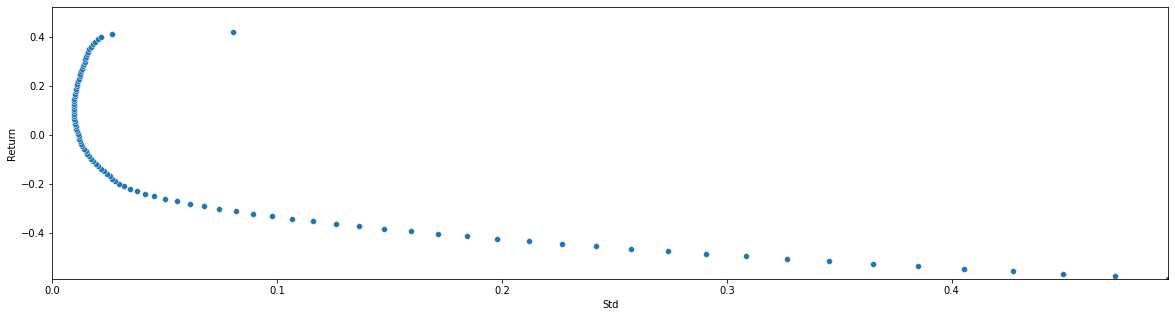

In [76]:
DisplayEffFrontier(returndf)

In [77]:
EfficientVsRiskFree(returndf,0.025)

Return                                             0.340247
Std                                                0.015854
Result    [0.0, 0.0, 0.27792405055054875, 0.0, 0.0, 0.0,...
Name: 91, dtype: object

In [78]:
EfficientVsRiskFree(returndf,0.025).Result

array([0.        , 0.        , 0.27792405, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.17319663, 0.17010398, 0.        , 0.24082659,
       0.        , 0.        , 0.        , 0.        , 0.13794875])

In [98]:
def Efficient_Select_Frontier_QP_Shift(ExistingPortfolio, Tickers, Margin=0.05, TimePeriod='1y',StartDate=None ,NoOfSelection=5 ,Resolution=4):

    stock_data = FetchData(Tickers,Period=TimePeriod,Start=StartDate)
    stock_mean_ret, stock_covariance = Calculation(stock_data)
    MinRet = 0.01#stock_mean_ret.values.min()
    MaxRet = 0.5#stock_mean_ret.values.max()
    m = gp.Model('PortFolio optimization')
    weight = m.addMVar(len(Tickers))
    Stock_Selected = m.addMVar(len(Tickers),vtype=GRB.BINARY)

    for i in range(len(Tickers)):
        #m.addConstr(weight[i]>=ExistingPortfolio[i])
        m.addConstr(Stock_Selected[i]>=weight[i])
        
        #print(ExistingPortfolio[i]-Margin,ExistingPortfolio[i]+Margin)
        m.addConstr(weight[i]>=ExistingPortfolio[i]-Margin)
        m.addConstr(weight[i]<=ExistingPortfolio[i]+Margin)

    m.addConstr(Stock_Selected.sum() <= NoOfSelection)
    m.addConstr(weight.sum() == 1)
    port_std = weight @ stock_covariance.values @ weight
    port_ret = weight @ stock_mean_ret.values
    returnrate = MinRet
    target = m.addConstr(port_ret == returnrate,'target')
    Frontier = pd.DataFrame([],columns=['Return','Std','Result'])
    for i in np.linspace(MinRet,MaxRet,Resolution):
        
        target[0].rhs = i
        #m.addConstr(port_ret <= weight @ stock_mean_ret.values)
        m.setObjective(port_std, GRB.MINIMIZE)
        m.update()
        m.optimize()
        if m.getAttr('SolCount')>0:
            t2=weight.x
            temp = pd.DataFrame([[i,m.ObjVal,t2]],columns=['Return','Std','Result'])

            Frontier = pd.concat([Frontier,temp],ignore_index=True)
    
    return(Frontier)

In [99]:
def Efficient_Select_Frontier_QP_Time(Tickers, TimePeriod='1y',StartDate=None ,NoOfSelection=5 ,Resolution=4):

    stock_data = FetchData(Tickers,Period=TimePeriod,Start=StartDate)
    stock_mean_ret, stock_covariance = Calculation(stock_data)
    MinRet = stock_mean_ret.values.min()
    MaxRet = stock_mean_ret.values.max()
    m = gp.Model('PortFolio optimization')
    weight = m.addMVar(len(Tickers))
    Stock_Selected = m.addMVar(len(Tickers),vtype=GRB.BINARY)

    for i in range(len(Tickers)):
        m.addConstr(Stock_Selected[i]>=weight[i])


    m.addConstr(Stock_Selected.sum() <= NoOfSelection)
    m.addConstr(weight.sum() == 1)
    port_std = weight @ stock_covariance.values @ weight
    port_ret = weight @ stock_mean_ret.values
    returnrate = MinRet
    target = m.addConstr(port_ret == returnrate,'target')
    Frontier = pd.DataFrame([],columns=['Return','Std','Result'])
    for i in np.linspace(MinRet,MaxRet,Resolution):
        
        target[0].rhs = i
        #m.addConstr(port_ret <= weight @ stock_mean_ret.values)
        m.setObjective(port_std, GRB.MINIMIZE)
        m.update()
        m.optimize()
        if m.getAttr('SolCount')>0:
            t2=weight.x
            temp = pd.DataFrame([[i,m.ObjVal,t2]],columns=['Return','Std','Result'])

            Frontier = pd.concat([Frontier,temp],ignore_index=True)
    
    return(Frontier)

In [100]:
Resultdf = Efficient_Select_Frontier_QP_Time(Tickers_List,'1y',StartDate='2020-01-01', NoOfSelection=5,Resolution=200)

[*********************100%***********************]  20 of 20 completed
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0x886fc9e6
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-01, 5e+00]
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 22 rows, 39 columns, 96 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 19 integer (19 binary)
Found heuristic solution: objective 0.5050259

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.505026 

Optimal solution


Solution count 1: 0.438057 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.380568817716e-01, best bound 4.380568817716e-01, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0xb2ff49fc
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-01, 5e+00]

MIP start from previous solve produced solution with objective 0.425355 (0.00s)
Loaded MIP start from previous solve with objective 0.425355

Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 22 rows, 39 columns, 97 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 19 integer (1


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         0.36530    0.36530  0.00%     -    0s

Explored 1 nodes (14 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.365304 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.653041591537e-01, best bound 3.653041591537e-01, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0xd885a2e0
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-0

Loaded MIP start from previous solve with objective 0.300853

Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 22 rows, 39 columns, 97 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 19 integer (19 binary)

Root relaxation: cutoff, 14 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         0.30085    0.30085  0.00%     -    0s

Explored 1 nodes (14 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.300853 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.008534247376e-01, best bound 3.008534247376e-01, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 r

Model fingerprint: 0x68c68ee1
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 5e+00]

MIP start from previous solve produced solution with objective 0.244705 (0.01s)
Loaded MIP start from previous solve with objective 0.244705

Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 22 rows, 39 columns, 97 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 19 integer (19 binary)

Root relaxation: cutoff, 16 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         0.24470    0.24470  0.00%     -    0s

Explored 1 nodes (16 simplex ite

Thread count was 8 (of 8 available processors)

Solution count 1: 0.204256 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.042558532212e-01, best bound 2.042558532212e-01, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0x97171241
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 5e+00]

MIP start from previous solve produced solution with objective 0.196858 (0.01s)
Loaded MIP start from previous solve with objective 0.196858

Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 22 rows, 39 columns, 97 nonzeros
Presolved model has 210 quadratic objective ter


Root relaxation: cutoff, 16 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         0.16333    0.16333  0.00%     -    0s

Explored 1 nodes (16 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.163327 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.633274187104e-01, best bound 1.633274187104e-01, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0x8993fe06
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [

  RHS range        [2e-01, 5e+00]

MIP start from previous solve produced solution with objective 0.130701 (0.00s)
Loaded MIP start from previous solve with objective 0.130701

Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 22 rows, 39 columns, 97 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 19 integer (19 binary)

Root relaxation: cutoff, 16 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         0.13070    0.13070  0.00%     -    0s

Explored 1 nodes (16 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.130701 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.307009724013e-01, best bound 1.307009724013e-01, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.

Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0xa4c06b62
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 5e+00]

MIP start from previous solve produced solution with objective 0.106377 (0.00s)
Loaded MIP start from previous solve with objective 0.106377

Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 22 rows, 39 columns, 97 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 19 integer (19 binary)

Root relaxation: cutoff, 20 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         0.10638    0

H    0     0                       0.0923142    0.09231  0.00%     -    0s

Explored 1 nodes (18 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 0.0923142 0.0924479 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.231420572874e-02, best bound 9.231420572874e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0x3d9e9ac6
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 5e+00]

MIP start from previous solve produced solution with objective 0.0899155 (0.00s)
Loaded MIP start from previous solve with objecti

Presolve time: 0.00s
Presolved: 22 rows, 39 columns, 97 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 19 integer (19 binary)

Root relaxation: cutoff, 29 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         0.07874    0.07874  0.00%     -    0s

Explored 1 nodes (29 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0787435 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.874354964979e-02, best bound 7.874354964979e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0x89060de7
Model has 210 quadratic objective te

Coefficient statistics:
  Matrix range     [8e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 5e+00]

MIP start from previous solve produced solution with objective 0.0671443 (0.00s)
Loaded MIP start from previous solve with objective 0.0671443

Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 22 rows, 39 columns, 97 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 19 integer (19 binary)

Root relaxation: cutoff, 29 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         0.06714    0.06714  0.00%     -    0s

Explored 1 nodes (29 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0671443 

O

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0x2b9a7ed0
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-02, 5e+00]

MIP start from previous solve produced solution with objective 0.0575163 (0.00s)
Loaded MIP start from previous solve with objective 0.0575163

Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 100 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: cutoff, 27 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0  


Optimal solution found (tolerance 1.00e-04)
Best objective 5.099892264111e-02, best bound 5.099892264111e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0x1c55ce18
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-02, 5e+00]

MIP start from previous solve produced solution with objective 0.0498597 (0.01s)
Loaded MIP start from previous solve with objective 0.0498597

Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 100 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: cutoff, 25 iterations, 0.00 seconds 

H    0     0                       0.0449709    0.04497  0.00%     -    0s

Explored 1 nodes (26 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 0.0449709 0.0449851 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.497090528095e-02, best bound 4.497090528095e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0x6a9cdbcc
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-02, 5e+00]

MIP start from previous solve produced solution with objective 0.0441267 (0.00s)
Loaded MIP start from previous solve with objecti

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  Matrix range     [8e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 5e+00]

MIP start from previous solve produced solution with objective 0.0348112 (0.01s)
Loaded MIP start from previous solve with objective 0.0348112

Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 100 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: objective 3.473769e-02, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.03474    0    6    0.03481    0.03474  0.21%     -    0s

Explored 1 nodes (25 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0348112 

Optimal solution found (tolerance 1.00e-04)
Be

Best objective 3.606545076012e-02, best bound 3.606545076012e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0xd1ab4a0b
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 5e+00]

MIP start from previous solve produced solution with objective 0.0363749 (0.00s)
Loaded MIP start from previous solve with objective 0.0363749

Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 100 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: objective 3.632723e-02, 28 iterations, 0.00 seconds (0.00 work units)

    Nodes 


Root relaxation: objective 3.810803e-02, 28 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.03811    0    7    0.03822    0.03811  0.28%     -    0s

Explored 1 nodes (28 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0382156 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.821556679387e-02, best bound 3.821556679387e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0x0244a78b
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  Q

Coefficient statistics:
  Matrix range     [8e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 5e+00]

MIP start from previous solve produced solution with objective 0.0410693 (0.00s)
Loaded MIP start from previous solve with objective 0.0410693

Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 100 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: objective 4.078515e-02, 27 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.04079    0    6    0.04107    0.04079  0.69%     -    0s

Explored 1 nodes (27 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0410693 

Optimal solution found


Explored 1 nodes (38 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.043583 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.358295953151e-02, best bound 4.358295953151e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0x59cb4961
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 5e+00]

MIP start from previous solve produced solution with objective 0.0441186 (0.00s)
Loaded MIP start from previous solve with objective 0.0441186

Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 100 nonzeros
Presol


Root relaxation: cutoff, 29 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         0.04732    0.04732  0.00%     -    0s

Explored 1 nodes (29 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0473164 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.731637484575e-02, best bound 4.731637484575e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0x6600c136
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range 


Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 100 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: cutoff, 29 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         0.05230    0.05230  0.00%     -    0s

Explored 1 nodes (29 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0522974 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.229735601031e-02, best bound 5.229735601031e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0xd7b3a9a8
Model has 210 quadratic objective 

  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 5e+00]

MIP start from previous solve produced solution with objective 0.0585259 (0.00s)
Loaded MIP start from previous solve with objective 0.0585259

Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 100 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: objective 5.851878e-02, 33 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.05852    0    6    0.05853    0.05852  0.01%     -    0s

Explored 1 nodes (33 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0585259 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.852590302520e-02, best bound 5.852590302520e-02, gap 0.0000%
Gurobi Optimizer version 9

Model fingerprint: 0x4f94a9d2
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 5e+00]

MIP start from previous solve produced solution with objective 0.066002 (0.00s)
Loaded MIP start from previous solve with objective 0.066002

Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 100 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: objective 6.593407e-02, 33 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.06593    0    6    0.06600    0.06593  0.10%     -    0s

Explored 1 nodes (33 simplex iterations) in 0.02 seco


Solution count 1: 0.0730191 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.301909155971e-02, best bound 7.301899326353e-02, gap 0.0001%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0xcd36e2fa
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-01, 5e+00]

MIP start from previous solve produced solution with objective 0.0745414 (0.00s)
Loaded MIP start from previous solve with objective 0.0745414

Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 100 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: cutoff

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         0.08291    0.08291  0.00%     -    0s

Explored 1 nodes (33 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0829145 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.291450957526e-02, best bound 8.291450957526e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0x107abed1
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-01, 5e+00]

MIP start from previous solve produced solution with objective


Root relaxation: cutoff, 28 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         0.09571    0.09571  0.00%     -    0s

Explored 1 nodes (28 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0957051 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.570506231763e-02, best bound 9.570506231763e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0xb517cdcf
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range 


Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 100 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: cutoff, 32 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         0.11285    0.11285  0.00%     -    0s

Explored 1 nodes (32 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.112854 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.128536999501e-01, best bound 1.128536999501e-01, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 23 rows, 40 columns and 100 nonzeros
Model fingerprint: 0xd99b44c8
Model has 210 quadratic objective t

In [101]:
A = EfficientVsRiskFree(Resultdf,0.025)

In [102]:
Resultdf

,Return,Std,Result
0,-0.377945,0.505026,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
1,-0.37382,0.491171,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9844865355869..."
2,-0.369696,0.477546,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9689730711738..."
3,-0.365571,0.464153,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9534596067608..."
4,-0.361446,0.450989,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9379461423477..."
...,...,...,...
195,0.426338,0.116669,"[0.7879513321799937, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
196,0.430463,0.120904,"[0.8409634991349957, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
197,0.434587,0.125559,"[0.8939756660899976, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
198,0.438712,0.130634,"[0.9469878330449981, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [103]:
CurrentPortfolio = EfficientVsRiskFree(Resultdf,0.025).Result

In [104]:
A

Return                                             0.269606
Std                                                0.050498
Result    [0.16874474683456334, 0.0, 0.22653069351536914...
Name: 157, dtype: object

In [105]:
RetMin=np.inf
RetMax=0
for i in range(len(CurrentPortfolio)):
    if CurrentPortfolio[i] > 0:
        RetMin = min(CurrentPortfolio[i],RetMin)
        RetMax = max(CurrentPortfolio[i],RetMax)
print(RetMin,RetMax)

0.16874474683456334 0.24399713778478624


In [106]:
NewReturndf = Efficient_Select_Frontier_QP_Shift(CurrentPortfolio,Tickers_List,TimePeriod='1y',StartDate='2021-01-01',Margin=0.3, NoOfSelection=6, Resolution=200)

[*********************100%***********************]  20 of 20 completed
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 63 rows, 40 columns and 140 nonzeros
Model fingerprint: 0x36925aac
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-06, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 6e+00]
Found heuristic solution: objective 0.0391338
Presolve removed 40 rows and 0 columns
Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 99 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: objective 1.093639e-02, 46 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl

     0     0    0.01073    0    7    0.01094    0.01073  1.97%     -    0s
     0     0    0.01073    0    7    0.01094    0.01073  1.97%     -    0s
     0     2    0.01073    0    7    0.01094    0.01073  1.97%     -    0s

Explored 11 nodes (86 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0109405 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.094047065481e-02, best bound 1.094047065481e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 63 rows, 40 columns and 140 nonzeros
Model fingerprint: 0x0dec006d
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-06, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-0


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.01051    0   11    0.01069    0.01051  1.65%     -    0s
     0     0    0.01051    0    7    0.01069    0.01051  1.65%     -    0s
     0     0    0.01051    0    7    0.01069    0.01051  1.65%     -    0s
     0     2    0.01051    0    7    0.01069    0.01051  1.65%     -    0s

Explored 9 nodes (85 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0106877 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.068767456006e-02, best bound 1.068767456006e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 63 rows, 40 columns and 140 nonzeros
Model fingerprint: 0x69e11abc
Model has 210 quadratic objective terms
Variable typ


Root relaxation: objective 1.035740e-02, 43 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.01036    0   10    0.01052    0.01036  1.50%     -    0s
     0     0    0.01036    0    7    0.01052    0.01036  1.50%     -    0s
     0     0    0.01039    0    6    0.01052    0.01039  1.20%     -    0s
     0     2    0.01039    0    6    0.01052    0.01039  1.20%     -    0s

Explored 6 nodes (76 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0105154 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.051536145949e-02, best bound 1.051536145949e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 63 rows, 40 columns and 140 non

  RHS range        [6e-02, 6e+00]

MIP start from previous solve produced solution with objective 0.0104743 (0.00s)
Loaded MIP start from previous solve with objective 0.0104743

Presolve removed 40 rows and 0 columns
Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 99 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: objective 1.026880e-02, 41 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.01027    0   10    0.01047    0.01027  1.96%     -    0s
     0     0    0.01027    0    8    0.01047    0.01027  1.96%     -    0s
     0     0    0.01032    0    8    0.01047    0.01032  1.47%     -    0s
     0     0    0.01035    0    8    0.01047    0.01035  1.21%     -    0s
     0     0    0.01042    0    8    0.01047    0.01042  0.56%     -    0


Solution count 1: 0.0105359 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.053588429560e-02, best bound 1.053588429560e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 63 rows, 40 columns and 140 nonzeros
Model fingerprint: 0x6e721f87
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-06, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-02, 6e+00]

MIP start from previous solve produced solution with objective 0.0105644 (0.00s)
Loaded MIP start from previous solve with objective 0.0105644

Presolve removed 40 rows and 0 columns
Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 99 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 intege

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.01020    0   11    0.01061    0.01020  3.80%     -    0s
     0     0    0.01020    0    8    0.01061    0.01020  3.80%     -    0s
     0     0    0.01027    0    8    0.01061    0.01027  3.18%     -    0s
     0     0    0.01031    0    8    0.01061    0.01031  2.77%     -    0s
     0     0    0.01031    0    7    0.01061    0.01031  2.77%     -    0s
     0     2    0.01038    0    7    0.01061    0.01038  2.16%     -    0s

Explored 12 nodes (147 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0106071 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.060712524436e-02, best bound 1.060712524436e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 63 rows, 40 columns and 140 nonzeros
Mode

Thread count was 8 (of 8 available processors)

Solution count 1: 0.0105937 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.059374361851e-02, best bound 1.059374361851e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 63 rows, 40 columns and 140 nonzeros
Model fingerprint: 0xe32de723
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-06, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-02, 6e+00]

MIP start from previous solve produced solution with objective 0.0105945 (0.00s)
Loaded MIP start from previous solve with objective 0.0105945

Presolve removed 40 rows and 0 columns
Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 99 nonzeros
Presolved model has 210 quadratic objective

Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: objective 1.021271e-02, 38 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.01021    0    9    0.01061    0.01021  3.78%     -    0s
     0     0    0.01021    0    9    0.01061    0.01021  3.78%     -    0s
     0     0    0.01022    0    9    0.01061    0.01022  3.73%     -    0s
     0     0    0.01031    0    9    0.01061    0.01031  2.84%     -    0s
     0     0    0.01033    0    9    0.01061    0.01033  2.65%     -    0s
     0     0    0.01033    0    5    0.01061    0.01033  2.65%     -    0s
     0     2    0.01033    0    5    0.01061    0.01033  2.65%     -    0s

Explored 5 nodes (115 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0106143 

Optimal solution found (to

     0     2    0.01024    0    6    0.01066    0.01024  3.92%     -    0s

Explored 5 nodes (90 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0106607 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.066067180086e-02, best bound 1.065968413934e-02, gap 0.0093%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 63 rows, 40 columns and 140 nonzeros
Model fingerprint: 0xad955a3d
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-06, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-02, 6e+00]

MIP start from previous solve produced solution with objective 0.0106764 (0.01s)
Loaded MIP start from previous solve with objective 0.01067

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.01030    0   10    0.01076    0.01030  4.25%     -    0s
     0     0    0.01030    0    9    0.01076    0.01030  4.25%     -    0s
     0     0    0.01036    0    9    0.01076    0.01036  3.68%     -    0s
     0     0    0.01043    0    7    0.01076    0.01043  3.05%     -    0s
     0     2    0.01043    0    7    0.01076    0.01043  3.05%     -    0s

Cutting planes:
  Cover: 1
  Flow cover: 2

Explored 23 nodes (250 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0107559 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.075591035376e-02, best bound 1.075591035376e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 63 rows, 40 columns and 140 nonzeros
Model fingerprint: 0xe3acacb5
Model

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 63 rows, 40 columns and 140 nonzeros
Model fingerprint: 0x1cc8a36c
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-06, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-02, 6e+00]

MIP start from previous solve produced solution with objective 0.0108926 (0.01s)
Loaded MIP start from previous solve with objective 0.0108926

Presolve removed 40 rows and 0 columns
Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 99 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: objective 1.037248e-02, 40 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntIn


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.01044    0    9    0.01097    0.01044  4.80%     -    0s
     0     0    0.01044    0    9    0.01097    0.01044  4.80%     -    0s
     0     0    0.01052    0    9    0.01097    0.01052  4.07%     -    0s
     0     0    0.01061    0    7    0.01097    0.01061  3.33%     -    0s
     0     2    0.01061    0    7    0.01097    0.01061  3.33%     -    0s

Cutting planes:
  Cover: 1

Explored 24 nodes (194 simplex iterations) in 0.04 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0109716 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.097164298806e-02, best bound 1.097164298806e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 63 rows, 40 co

Model fingerprint: 0x24e4051b
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-06, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-02, 6e+00]

MIP start from previous solve produced solution with objective 0.0110385 (0.01s)
Loaded MIP start from previous solve with objective 0.0110385

Presolve removed 40 rows and 0 columns
Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 99 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: objective 1.055313e-02, 38 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.01055    0    9    0.01104    0.01055  4.40%     -    0s
     0     0  

     0     0    0.01094    0   10    0.01113    0.01094  1.67%     -    0s
     0     0    0.01100    0    7    0.01113    0.01100  1.14%     -    0s
     0     2    0.01100    0    7    0.01113    0.01100  1.14%     -    0s

Explored 14 nodes (117 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0111288 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.112882925351e-02, best bound 1.112882925351e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 63 rows, 40 columns and 140 nonzeros
Model fingerprint: 0x375df12f
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-06, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-

Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 99 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: objective 1.079731e-02, 34 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.01080    0    9    0.01128    0.01080  4.28%     -    0s
     0     0    0.01080    0    9    0.01128    0.01080  4.28%     -    0s
     0     0    0.01095    0    9    0.01128    0.01095  2.96%     -    0s
     0     0    0.01108    0    6    0.01128    0.01108  1.75%     -    0s
     0     2    0.01108    0    6    0.01128    0.01108  1.75%     -    0s

Explored 14 nodes (108 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.01128 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     0     0    0.01211    0    7    0.01266    0.01211  4.34%     -    0s
     0     0    0.01211    0    7    0.01266    0.01211  4.34%     -    0s
     0     2    0.01211    0    7    0.01266    0.01211  4.34%     -    0s

Explored 16 nodes (102 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0126589 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.265890181404e-02, best bound 1.265890181404e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 63 rows, 40 columns and 140 nonzeros
Model fingerprint: 0x66b2f746
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-06, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.01242    0   10    0.01297    0.01242  4.21%     -    0s
     0     0    0.01242    0    7    0.01297    0.01242  4.21%     -    0s
     0     0    0.01242    0    7    0.01297    0.01242  4.21%     -    0s
     0     2    0.01242    0    7    0.01297    0.01242  4.21%     -    0s

Explored 17 nodes (103 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0129652 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.296520224971e-02, best bound 1.296520224971e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 63 rows, 40 columns and 140 nonzeros
Model fingerprint: 0xd515ce2d
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matr


Root relaxation: objective 1.275369e-02, 33 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.01275    0   10    0.01331    0.01275  4.15%     -    0s
     0     0    0.01275    0    7    0.01331    0.01275  4.15%     -    0s
     0     0    0.01275    0    7    0.01331    0.01275  4.15%     -    0s
H    0     0                       0.0133009    0.01275  4.11%     -    0s
     0     2    0.01275    0    7    0.01330    0.01275  4.11%     -    0s

Explored 16 nodes (96 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 0.0133009 0.0133053 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.330086682015e-02, best bound 1.330086682015e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical p

Loaded MIP start from previous solve with objective 0.0135725

Presolve removed 40 rows and 0 columns
Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 99 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: objective 1.311219e-02, 30 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.01311    0    9    0.01357    0.01311  3.39%     -    0s
     0     0    0.01311    0    5    0.01357    0.01311  3.39%     -    0s
     0     0    0.01311    0    5    0.01357    0.01311  3.39%     -    0s
     0     2    0.01311    0    5    0.01357    0.01311  3.39%     -    0s

Explored 10 nodes (74 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0135725 

Optimal solution found (tolerance 

  QObjective range [8e-06, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-02, 6e+00]

MIP start from previous solve produced solution with objective 0.0138822 (0.01s)
Loaded MIP start from previous solve with objective 0.0138822

Presolve removed 40 rows and 0 columns
Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 99 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: objective 1.349906e-02, 30 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.01350    0    9    0.01388    0.01350  2.76%     -    0s
     0     0    0.01350    0    4    0.01388    0.01350  2.76%     -    0s
     0     0    0.01350    0    4    0.01388    0.01350  2.76%     -    0s
     0     2    0.01350    0    4    0.01388    0.01350  2.76%     -    0s

Expl

Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-06, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-02, 6e+00]

MIP start from previous solve produced solution with objective 0.0142299 (0.01s)
Loaded MIP start from previous solve with objective 0.0142299

Presolve removed 40 rows and 0 columns
Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 99 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: objective 1.391621e-02, 30 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.01392    0    9    0.01423    0.01392  2.20%     -    0s
     0     0    0.01392    0    4    0.01423

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 63 rows, 40 columns and 140 nonzeros
Model fingerprint: 0x33b13fae
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-06, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-02, 6e+00]

MIP start from previous solve produced solution with objective 0.0146156 (0.00s)
Loaded MIP start from previous solve with objective 0.0146156

Presolve removed 40 rows and 0 columns
Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 99 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: objective 1.436365e-02, 30 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntIn


Optimal solution found (tolerance 1.00e-04)
Best objective 1.495147618271e-02, best bound 1.495147618271e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 63 rows, 40 columns and 140 nonzeros
Model fingerprint: 0x3c1289b2
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-06, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-02, 6e+00]

MIP start from previous solve produced solution with objective 0.0150393 (0.02s)
Loaded MIP start from previous solve with objective 0.0150393

Presolve removed 40 rows and 0 columns
Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 99 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation

     0     2    0.01525    0    4    0.01539    0.01525  0.94%     -    0s

Explored 4 nodes (51 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0153904 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.539041536206e-02, best bound 1.539041536206e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 63 rows, 40 columns and 140 nonzeros
Model fingerprint: 0xdfbec816
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-06, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-02, 6e+00]

MIP start from previous solve produced solution with objective 0.0154802 (0.00s)
Loaded MIP start from previous solve with objective 0.01548

     0     0    0.01578    0    4    0.01586    0.01578  0.53%     -    0s
     0     0    0.01578    0    4    0.01586    0.01578  0.53%     -    0s
     0     2    0.01578    0    4    0.01586    0.01578  0.53%     -    0s

Explored 4 nodes (51 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0158616 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.586157983226e-02, best bound 1.586157983226e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 63 rows, 40 columns and 140 nonzeros
Model fingerprint: 0x47b99278
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-06, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-02

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.01634    0    9    0.01639    0.01634  0.29%     -    0s
     0     0    0.01634    0    4    0.01639    0.01634  0.29%     -    0s
     0     0    0.01634    0    4    0.01639    0.01634  0.29%     -    0s
     0     2    0.01634    0    4    0.01639    0.01634  0.29%     -    0s

Explored 4 nodes (51 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0163877 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.638773842414e-02, best bound 1.638773842414e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 63 rows, 40 columns and 140 nonzeros
Model fingerprint: 0x0b89bb51
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix

Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: objective 1.693711e-02, 27 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.01694    0    8    0.01697    0.01694  0.18%     -    0s
     0     0    0.01694    0    3    0.01697    0.01694  0.18%     -    0s
     0     0    0.01694    0    3    0.01697    0.01694  0.18%     -    0s
     0     2    0.01694    0    3    0.01697    0.01694  0.18%     -    0s

Explored 4 nodes (46 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.016967 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.696696447694e-02, best bound 1.696696447694e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical c


Presolve removed 40 rows and 0 columns
Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 99 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: objective 1.757835e-02, 27 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.01758    0    8    0.01758    0.01758  0.03%     -    0s
     0     0     cutoff    0         0.01758    0.01758  0.00%     -    0s

Explored 1 nodes (41 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0175837 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.758368867157e-02, best bound 1.758368867157e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 th

Optimize a model with 63 rows, 40 columns and 140 nonzeros
Model fingerprint: 0x2aee56dd
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-06, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-02, 6e+00]

MIP start from previous solve produced solution with objective 0.0184364 (0.00s)
Loaded MIP start from previous solve with objective 0.0184364

Presolve removed 40 rows and 0 columns
Presolve time: 0.00s
Presolved: 23 rows, 40 columns, 99 nonzeros
Presolved model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)

Root relaxation: cutoff, 22 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         0.01844  


Explored 1 nodes (22 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0.0192817 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.928168936045e-02, best bound 1.928168936045e-02, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 63 rows, 40 columns and 140 nonzeros
Model fingerprint: 0xa620c6f4
Model has 210 quadratic objective terms
Variable types: 20 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-06, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-02, 6e+00]

MIP start from previous solve produced solution with objective 0.0194655 (0.00s)
Loaded MIP start from previous solve with objective 0.0194655

Presolve removed 40 rows and 0 columns
Presolve time: 0.00s
Presolved: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [107]:
EfficientVsRiskFree(NewReturndf,0.025).Result

array([0.        , 0.        , 0.21871558, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.04866236,
       0.        , 0.18240954, 0.15755532, 0.        , 0.18075557,
       0.        , 0.        , 0.        , 0.        , 0.21190162])

In [108]:
CurrentPortfolio

array([0.16874475, 0.        , 0.22653069, 0.        , 0.        ,
       0.        , 0.        , 0.24399714, 0.        , 0.        ,
       0.        , 0.        , 0.17265353, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.18807389, 0.        ])